In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from numpy import sin, cos, pi
import matplotlib.pyplot as plt

In [2]:
## Parameters
# limb lengths
l_1, l_2 = 0.5, 0.5
# limb masses
m_1, m_2 = 7, 7
# body mass
m_A = 75
# gravity
g = 9.81
# joint stiffnesses
k_B = 1
# joint damping
b_B = 1
# joint neutral angles
psi_B = pi/12
# Walking speed
v = 0.5

In [3]:
# Made-up data
#n = 30 # keep below 30 for stability
#t_array = np.linspace(0, 10, n)
#y_array = 0.1 * cos(pi * t_array)
#theta_1_array = sin(pi * t_array)

C:\Users\mehra\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\mehra\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


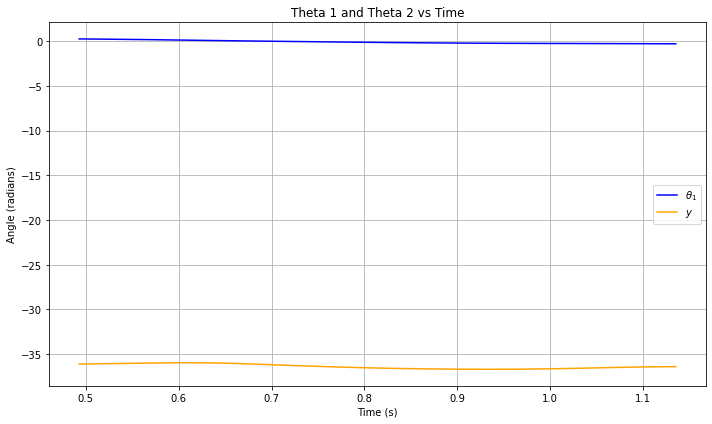

In [4]:
# Real data
import pandas as pd

# Load the data
data = pd.read_csv("Walking Data (theta1, theta2, y).csv")

# Convert time from milliseconds to seconds for plotting
t_array = data["Time (ms)"].to_numpy() / 1000.0
t_array = t_array[15:35]
theta_1_array = data["Theta 1"].to_numpy() * np.pi / 180
theta_1_array = theta_1_array[15:35]
y_array = data["y"].to_numpy()
y_array = y_array[15:35]

theta_2_array = data["Theta 2"].to_numpy()* np.pi / 180
theta_2_array = theta_2_array[15:35]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_array, theta_1_array, color="blue", label=r"$ \theta_1 $")
plt.plot(t_array, y_array, color="orange", label=r'$y$')

plt.title("Theta 1 and Theta 2 vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (radians)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Create interpolators for data
y_interp = CubicSpline(t_array, y_array)
a_interp = y_interp.derivative(2)

theta_1_interp = CubicSpline(t_array, theta_1_array)
omega_1_interp = theta_1_interp.derivative(1)
alpha_1_interp = theta_1_interp.derivative(2)

In [6]:
# functions for inputs of time from interpolators
def y_func(t):
    return y_interp(t)

def a_func(t):
    return a_interp(t)

def theta_1_func(t):
    return theta_1_interp(t)

def omega_1_func(t):
    return omega_1_interp(t)

def alpha_1_func(t):
    return alpha_1_interp(t)

In [7]:
def swing(t, state):
    # determine input values
    a = a_func(t)
    theta_1 = theta_1_func(t)
    omega_1 = omega_1_func(t)
    alpha_1 = alpha_1_func(t)

    # unpack state
    theta_2 = state[0]
    omega_2 = state[1]

    # calculate derivatives with EOMs
    alpha_2 = 3*b_B*omega_1/(l_2**2*m_2) - 3*b_B*omega_2/(l_2**2*m_2) - 3*g*sin(theta_2)/(2*l_2) - 3*k_B*psi_B/(l_2**2*m_2) + 3*k_B*theta_1/(l_2**2*m_2) - 3*k_B*theta_2/(l_2**2*m_2) + 3*l_1*sin(theta_1 - theta_2)*omega_1**2/(2*l_2) - 3*l_1*cos(theta_1 - theta_2)*alpha_1/(2*l_2) - 3*sin(theta_2)*a/(2*l_2)

    # Pack derivatives into array and return
    return np.array((omega_2, alpha_2))


In [8]:
# Initial conditions
theta_2_0 = theta_2_array[0]
omega_2_0 = (theta_2_array[1] - theta_2_array[0]) / (t_array[1] - t_array[0])
state0 = np.array([theta_2_0, omega_2_0])

In [9]:
# Solve IVP
t_span = (t_array[0], t_array[-1])

t_eval = np.linspace(*t_span, 1000)
solution = solve_ivp(swing, t_span, state0, t_eval= None)

In [10]:
# Unpack Solution
t = solution.t
state = solution.y
theta_2 = state[0, :]
omega_2 = state[0, :]

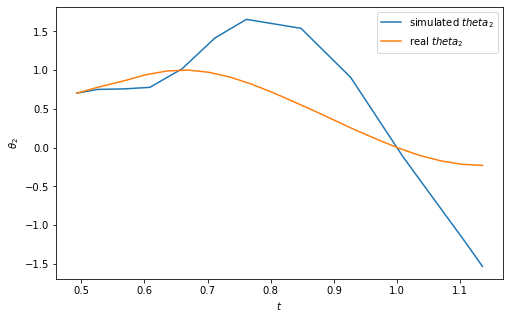

In [11]:
# Plot Solution
plt.figure(figsize=(8,5))
plt.plot(t, theta_2, label="simulated $theta_2$")
plt.plot(t_array, theta_2_array, label= "real $theta_2$")
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta_2$')
plt.legend()
plt.show()

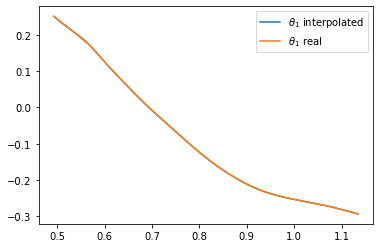

In [12]:
#plt.plot(t_eval, y_func(t_eval), label=r"$y$")
plt.plot(t_eval, theta_1_func(t_eval), label=r"$\theta_1$ interpolated")
plt.plot(t_array, theta_1_array, label=r"$\theta_1$ real")
#plt.plot(t_array, theta_2_array, label=r"$\theta_2$")
plt.legend()
plt.show()

In [13]:
# Havent worked on the optimizer yet

# Optimizer_updated

In [14]:
from scipy.optimize import least_squares

def simulate_theta2(params, t_meas, theta2_meas, state0, l_1, l_2):
    # Unpack parameters (excluding l_1 and l_2)
    k_B, b_B, psi_B, m_1, m_2 = params

    def swing(t, state):
        theta_2, omega_2 = state
        a = a_func(t)
        theta_1 = theta_1_func(t)
        omega_1 = omega_1_func(t)
        alpha_1 = alpha_1_func(t)

        alpha_2 = (3*b_B*omega_1/(l_2**2*m_2)
                   - 3*b_B*omega_2/(l_2**2*m_2)
                   - 3*g*sin(theta_2)/(2*l_2)
                   - 3*k_B*psi_B/(l_2**2*m_2)
                   + 3*k_B*theta_1/(l_2**2*m_2)
                   - 3*k_B*theta_2/(l_2**2*m_2)
                   + 3*l_1*sin(theta_1 - theta_2)*omega_1**2/(2*l_2)
                   - 3*l_1*cos(theta_1 - theta_2)*alpha_1/(2*l_2)
                   - 3*sin(theta_2)*a/(2*l_2))
        
        return [omega_2, alpha_2]

    sol = solve_ivp(swing, (t_meas[0], t_meas[-1]), state0, t_eval=t_meas)

    if not sol.success:
        return np.full_like(theta2_meas, np.inf)  # penalize bad sim

    theta2_sim = sol.y[0]
    return theta2_sim - theta2_meas

def residuals(params):
    return simulate_theta2(params, t_array, theta_2_array, state0, l_1_fixed, l_2_fixed)


In [47]:
# Initial guesses for [k_B, b_B, psi_B, l_1, l_2, m_1, m_2]

# K_B = 9.9532119,   
# b_B = 10.0895001, 
# psi_B = 0.2482801, 
# m_1 = 7.        
# m_2 = 7.04062718]

#H = 1.75

l_1_fixed = 0.46 # 0.30 * H
l_2_fixed = 0.4 # 0.30 * H

p0 = [
      9,        # k_B
      10,        # b_B
      np.pi/12,  # psi_B
      14.0, 14.0    # m1, m2
     ]

# Reasonable physical bounds for stability and realism
lower_bounds = [
                1, # k_B
                9, # b_B
                0.0,  # psi_B
                10.0,  # m1
                10.0   # m2
                ]

upper_bounds = [
                20,    # k_B
                20,    # b_B
                np.pi/2, # psi_B
                #1.0, 1.0 # l_1, l_2
                20,    # m1
                20     # m2
               ]


In [48]:
result = least_squares(residuals,
                       x0=p0,
                       bounds=(lower_bounds, upper_bounds),
                       verbose=2)

print("Optimized parameters:", result.x)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3003e-01                                    1.55e+01    
       1              2         3.1067e-01      1.94e-02       4.74e-02       9.99e+00    
       2              5         3.1031e-01      3.60e-04       7.37e-04       3.96e+01    
       3              6         3.0987e-01      4.39e-04       2.57e-04       8.88e+00    
       4              8         3.0979e-01      8.54e-05       4.60e-05       2.31e+01    
       5             12         3.0979e-01      1.71e-06       2.01e-06       8.86e+00    
       6             13         3.0979e-01      6.72e-07       1.44e-06       2.31e+01    
       7             14         3.0979e-01      9.39e-07       5.04e-07       2.39e+00    
       8             15         3.0979e-01      0.00e+00       0.00e+00       2.39e+00    
`xtol` termination condition is satisfied.
Function evaluations 15, initial cost 3.3003e-0

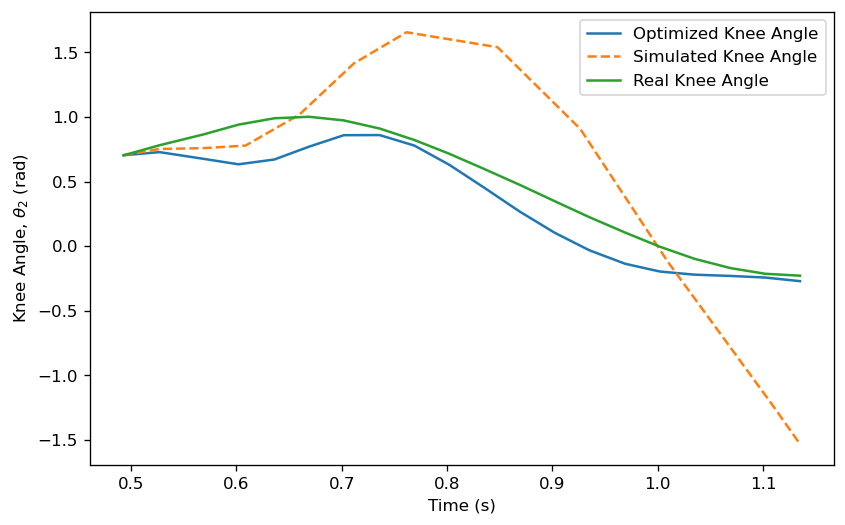

In [50]:
theta2_fit = simulate_theta2(result.x, t_array, theta_2_array, state0, l_1_fixed, l_2_fixed) + theta_2_array

plt.figure(figsize=(8, 5), dpi = 120)
plt.plot(t_array, theta2_fit, label="Optimized Knee Angle")
plt.plot(t, theta_2, "--", label="Simulated Knee Angle")
plt.plot(t_array, theta_2_array, label="Real Knee Angle")
plt.xlabel("Time (s)")
plt.ylabel("Knee Angle, $\\theta_2$ (rad)")
plt.legend()
plt.show()
